<a href="https://www.kaggle.com/code/basselashraf/melting-point-prediction-challenge?scriptVersionId=295859204" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Melting Point Prediction Challenge
Predicting melting points (Tm) of organic molecules using group contribution features.

**Evaluation Metric:** Mean Absolute Error (MAE) - lower is better

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading

In [2]:
# Load datasets
train = pd.read_csv('/kaggle/input/melting-point/train.csv')
test = pd.read_csv('/kaggle/input/melting-point/test.csv')
sample_submission = pd.read_csv('/kaggle/input/melting-point/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"\nTrain columns: {train.columns.tolist()[:10]}... + {len(train.columns)-10} more")
train.head()

Train shape: (2662, 427)
Test shape: (666, 426)
Sample submission shape: (666, 2)

Train columns: ['id', 'SMILES', 'Tm', 'Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7']... + 417 more


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,Group 11,Group 12,Group 13,Group 14,Group 15,Group 16,Group 17,Group 18,Group 19,Group 20,Group 21,Group 22,...,Group 400,Group 401,Group 402,Group 403,Group 404,Group 405,Group 406,Group 407,Group 408,Group 409,Group 410,Group 411,Group 412,Group 413,Group 414,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2,4,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2. Exploratory Data Analysis

In [3]:
# Target variable statistics
print("Target Variable (Tm) Statistics:")
print(train['Tm'].describe())
print(f"\nMissing values in Tm: {train['Tm'].isna().sum()}")

Target Variable (Tm) Statistics:
count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64

Missing values in Tm: 0


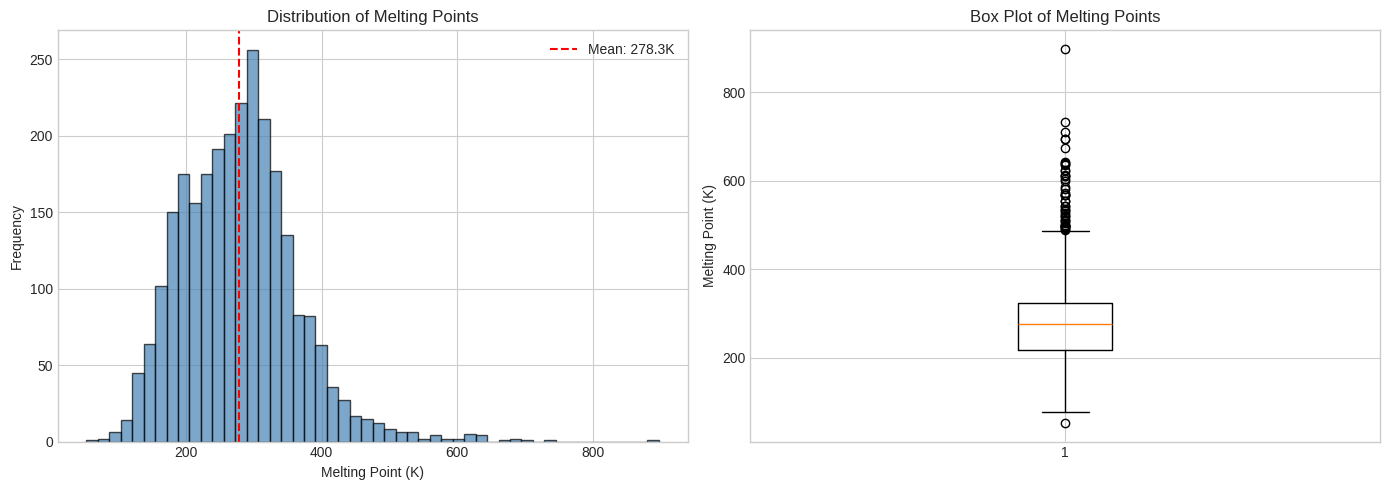

In [4]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train['Tm'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Melting Point (K)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Melting Points')
axes[0].axvline(train['Tm'].mean(), color='red', linestyle='--', label=f'Mean: {train["Tm"].mean():.1f}K')
axes[0].legend()

# Box plot
axes[1].boxplot(train['Tm'], vert=True)
axes[1].set_ylabel('Melting Point (K)')
axes[1].set_title('Box Plot of Melting Points')

plt.tight_layout()
plt.show()

In [5]:
# Analyze feature sparsity
group_cols = [col for col in train.columns if col.startswith('Group')]
print(f"Number of Group features: {len(group_cols)}")

# Calculate sparsity (percentage of zeros) for each feature
sparsity = (train[group_cols] == 0).mean() * 100
print(f"\nFeature Sparsity Summary:")
print(f"  Mean sparsity: {sparsity.mean():.1f}%")
print(f"  Min sparsity: {sparsity.min():.1f}%")
print(f"  Max sparsity: {sparsity.max():.1f}%")
print(f"  Features with >99% zeros: {(sparsity > 99).sum()}")

# Check for missing values
missing = train[group_cols].isna().sum().sum()
print(f"\nMissing values in features: {missing}")

Number of Group features: 424

Feature Sparsity Summary:
  Mean sparsity: 99.0%
  Min sparsity: 47.0%
  Max sparsity: 100.0%
  Features with >99% zeros: 347

Missing values in features: 0


## 3. Feature Engineering & Preparation

In [6]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 48.6 MB/s eta 0:00:00


In [7]:
# Extract molecular descriptors from SMILES using RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def extract_mol_features(smiles):
    """Extract molecular descriptors from SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [np.nan] * 15
        return [
            Descriptors.MolWt(mol),                    # Molecular weight
            Descriptors.MolLogP(mol),                  # LogP
            Descriptors.TPSA(mol),                     # Topological PSA
            Descriptors.NumHDonors(mol),               # H-bond donors
            Descriptors.NumHAcceptors(mol),            # H-bond acceptors
            Descriptors.NumRotatableBonds(mol),        # Rotatable bonds
            Descriptors.NumAromaticRings(mol),         # Aromatic rings
            Descriptors.FractionCSP3(mol),             # Fraction sp3 carbons
            rdMolDescriptors.CalcNumRings(mol),        # Total rings
            rdMolDescriptors.CalcNumHeavyAtoms(mol),   # Heavy atoms
            Descriptors.NumValenceElectrons(mol),      # Valence electrons
            Descriptors.NumRadicalElectrons(mol),      # Radical electrons
            Descriptors.BalabanJ(mol) if rdMolDescriptors.CalcNumRings(mol) > 0 else 0,  # Balaban index
            Descriptors.BertzCT(mol),                  # Bertz complexity
            Descriptors.HallKierAlpha(mol),            # Hall-Kier alpha
        ]
    except:
        return [np.nan] * 15

mol_feature_names = ['MolWt', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotBonds', 
                     'AromaticRings', 'FracCSP3', 'NumRings', 'HeavyAtoms',
                     'ValenceE', 'RadicalE', 'BalabanJ', 'BertzCT', 'HKAlpha']

print("Extracting molecular features from SMILES...")
train_mol_features = np.array([extract_mol_features(s) for s in train['SMILES']])
test_mol_features = np.array([extract_mol_features(s) for s in test['SMILES']])

# Handle any NaN values
train_mol_features = np.nan_to_num(train_mol_features, nan=0)
test_mol_features = np.nan_to_num(test_mol_features, nan=0)

print(f"Molecular features shape: {train_mol_features.shape}")

Extracting molecular features from SMILES...
Molecular features shape: (2662, 15)


In [8]:
# Combine Group features with molecular descriptors
feature_cols = [col for col in train.columns if col.startswith('Group')]

X_train_groups = train[feature_cols].values
y_train = train['Tm'].values
X_test_groups = test[feature_cols].values
test_ids = test['id'].values

# Remove zero-variance Group features
non_zero_var = X_train_groups.var(axis=0) > 0
X_train_groups = X_train_groups[:, non_zero_var]
X_test_groups = X_test_groups[:, non_zero_var]

# Combine all features
X_train_full = np.hstack([X_train_groups, train_mol_features])
X_test_full = np.hstack([X_test_groups, test_mol_features])

print(f"Group features: {X_train_groups.shape[1]}")
print(f"Molecular features: {train_mol_features.shape[1]}")
print(f"Total features: {X_train_full.shape[1]}")
print(f"\nX_train shape: {X_train_full.shape}")
print(f"X_test shape: {X_test_full.shape}")

Group features: 337
Molecular features: 15
Total features: 352

X_train shape: (2662, 352)
X_test shape: (666, 352)


## 4. Hyperparameter Optimization with Optuna

In [9]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'verbosity': 0,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 100.0, log=True),
        'gamma': trial.suggest_float('gamma', 0, 10),
    }
    
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X_train_full, y_train, cv=5, scoring='neg_mean_absolute_error')
    return -scores.mean()

# Run extended optimization
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"\nBest CV MAE: {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

  0%|          | 0/100 [00:00<?, ?it/s]


Best CV MAE: 29.8349

Best parameters:
  n_estimators: 2872
  learning_rate: 0.02050372833026717
  max_depth: 9
  min_child_weight: 3
  subsample: 0.5556465858469123
  colsample_bytree: 0.6097902154692211
  colsample_bylevel: 0.5462285097881074
  reg_alpha: 0.02283306484540968
  reg_lambda: 0.006609056234599023
  gamma: 1.7586636194887841


In [10]:
# Train final optimized XGBoost
best_params = study.best_params.copy()
best_params.update({
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'random_state': 42
})

print("Training optimized XGBoost with molecular features...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_oof = np.zeros(len(y_train))
xgb_test_preds = np.zeros(len(X_test_full))
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
    X_tr, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_tr, y_tr)
    
    xgb_oof[val_idx] = model.predict(X_val)
    xgb_test_preds += model.predict(X_test_full) / 5
    
    fold_mae = mean_absolute_error(y_val, xgb_oof[val_idx])
    fold_scores.append(fold_mae)
    print(f"  Fold {fold+1}: MAE = {fold_mae:.4f}")

xgb_mae = mean_absolute_error(y_train, xgb_oof)
print(f"\nXGBoost CV MAE: {xgb_mae:.4f}")

Training optimized XGBoost with molecular features...
  Fold 1: MAE = 30.2060
  Fold 2: MAE = 30.4858
  Fold 3: MAE = 29.6731
  Fold 4: MAE = 29.4842
  Fold 5: MAE = 29.4097

XGBoost CV MAE: 29.8522


In [11]:
# Train LightGBM with optimized parameters
print("\nTraining LightGBM...")
lgb_params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'verbosity': -1,
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'max_depth': 12,
    'num_leaves': 64,
    'min_child_samples': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42
}

lgb_oof = np.zeros(len(y_train))
lgb_test_preds = np.zeros(len(X_test_full))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
    X_tr, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(X_tr, y_tr)
    
    lgb_oof[val_idx] = model.predict(X_val)
    lgb_test_preds += model.predict(X_test_full) / 5
    
    fold_mae = mean_absolute_error(y_val, lgb_oof[val_idx])
    print(f"  Fold {fold+1}: MAE = {fold_mae:.4f}")

lgb_mae = mean_absolute_error(y_train, lgb_oof)
print(f"\nLightGBM CV MAE: {lgb_mae:.4f}")


Training LightGBM...
  Fold 1: MAE = 31.0305
  Fold 2: MAE = 31.7112
  Fold 3: MAE = 29.9109
  Fold 4: MAE = 31.0427
  Fold 5: MAE = 30.0874

LightGBM CV MAE: 30.7570


## 5. Stacking Ensemble

In [12]:
# Create stacking features from OOF predictions
stack_train = np.column_stack([xgb_oof, lgb_oof])
stack_test = np.column_stack([xgb_test_preds, lgb_test_preds])

# Train meta-learner (Ridge regression on stacked predictions)
meta_model = Ridge(alpha=1.0)
meta_oof = np.zeros(len(y_train))
meta_test_preds = np.zeros(len(X_test_full))

print("Training stacking meta-learner...")
for fold, (train_idx, val_idx) in enumerate(kf.split(stack_train)):
    meta_model.fit(stack_train[train_idx], y_train[train_idx])
    meta_oof[val_idx] = meta_model.predict(stack_train[val_idx])
    meta_test_preds += meta_model.predict(stack_test) / 5
    fold_mae = mean_absolute_error(y_train[val_idx], meta_oof[val_idx])
    print(f"  Fold {fold+1}: MAE = {fold_mae:.4f}")

stack_mae = mean_absolute_error(y_train, meta_oof)
print(f"\nStacking Ensemble CV MAE: {stack_mae:.4f}")

# Simple weighted average ensemble
best_weight = 0
best_ensemble_mae = float('inf')
for w in np.arange(0, 1.01, 0.05):
    blend = w * xgb_oof + (1-w) * lgb_oof
    mae = mean_absolute_error(y_train, blend)
    if mae < best_ensemble_mae:
        best_ensemble_mae = mae
        best_weight = w

print(f"\nBest blend weight (XGB): {best_weight:.2f}")
print(f"Best blend CV MAE: {best_ensemble_mae:.4f}")

Training stacking meta-learner...
  Fold 1: MAE = 30.3829
  Fold 2: MAE = 31.0014
  Fold 3: MAE = 29.9986
  Fold 4: MAE = 30.1252
  Fold 5: MAE = 29.3380

Stacking Ensemble CV MAE: 30.1696

Best blend weight (XGB): 0.95
Best blend CV MAE: 29.8507


In [13]:
# Use best performing predictions
# Compare all methods and choose best
results = {
    'XGBoost': (xgb_mae, xgb_test_preds),
    'LightGBM': (lgb_mae, lgb_test_preds),
    'Stacking': (stack_mae, meta_test_preds),
    'Blend': (best_ensemble_mae, best_weight * xgb_test_preds + (1-best_weight) * lgb_test_preds)
}

print("="*50)
print("FINAL RESULTS")
print("="*50)
for name, (mae, _) in results.items():
    print(f"{name:12s} CV MAE: {mae:.4f}")
print("="*50)

# Select best model
best_model = min(results.items(), key=lambda x: x[1][0])
print(f"\nBest model: {best_model[0]} (MAE: {best_model[1][0]:.4f})")

# Generate submission
final_preds = best_model[1][1]
submission = pd.DataFrame({
    'id': test_ids,
    'Tm': final_preds
})

submission.to_csv('submission.csv', index=False)
print(f"\nSubmission saved to 'submission.csv'")
print(f"Predictions: {len(submission)} samples")
print(f"Range: {final_preds.min():.2f} - {final_preds.max():.2f}")
submission.head(10)

FINAL RESULTS
XGBoost      CV MAE: 29.8522
LightGBM     CV MAE: 30.7570
Stacking     CV MAE: 30.1696
Blend        CV MAE: 29.8507

Best model: Blend (MAE: 29.8507)

Submission saved to 'submission.csv'
Predictions: 666 samples
Range: 91.82 - 641.62


,id,Tm
0,1022,339.358493
1,1146,324.211079
2,79,209.555789
3,2279,209.167229
4,1342,248.808900
5,2082,338.335013
6,29,282.064940
7,515,308.059347
8,2309,268.374286
9,1177,252.982352


## 7. Advanced Feature Engineering & Deeper Optimization

In [14]:
# Add Morgan Fingerprints for more molecular information
from rdkit.Chem import AllChem

def get_morgan_fingerprints(smiles, radius=2, n_bits=256):
    """Generate Morgan fingerprints from SMILES."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(n_bits)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return np.array(fp)
    except:
        return np.zeros(n_bits)

print("Generating Morgan fingerprints...")
train_fps = np.array([get_morgan_fingerprints(s) for s in train['SMILES']])
test_fps = np.array([get_morgan_fingerprints(s) for s in test['SMILES']])

# Add interaction features between key descriptors
print("Creating interaction features...")
train_interactions = np.column_stack([
    train_mol_features[:, 0] * train_mol_features[:, 1],  # MolWt * LogP
    train_mol_features[:, 0] / (train_mol_features[:, 9] + 1),  # MolWt / HeavyAtoms
    train_mol_features[:, 2] * train_mol_features[:, 3],  # TPSA * HBD
    train_mol_features[:, 6] * train_mol_features[:, 8],  # AromaticRings * NumRings
    np.log1p(train_mol_features[:, 0]),  # log MolWt
    train_mol_features[:, 3] + train_mol_features[:, 4],  # HBD + HBA
])

test_interactions = np.column_stack([
    test_mol_features[:, 0] * test_mol_features[:, 1],
    test_mol_features[:, 0] / (test_mol_features[:, 9] + 1),
    test_mol_features[:, 2] * test_mol_features[:, 3],
    test_mol_features[:, 6] * test_mol_features[:, 8],
    np.log1p(test_mol_features[:, 0]),
    test_mol_features[:, 3] + test_mol_features[:, 4],
])

# Combine all features
X_train_enhanced = np.hstack([X_train_full, train_fps, train_interactions])
X_test_enhanced = np.hstack([X_test_full, test_fps, test_interactions])

print(f"\nEnhanced features: {X_train_enhanced.shape[1]}")
print(f"  - Original: {X_train_full.shape[1]}")
print(f"  - Morgan FPs: {train_fps.shape[1]}")
print(f"  - Interactions: {train_interactions.shape[1]}")

Generating Morgan fingerprints...
Creating interaction features...

Enhanced features: 614
  - Original: 352
  - Morgan FPs: 256
  - Interactions: 6


In [15]:
# Extended Optuna optimization with enhanced features
def objective_enhanced(trial):
    params = {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'verbosity': 0,
        'random_state': 42,
        'tree_method': 'hist',
        'n_estimators': trial.suggest_int('n_estimators', 2000, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.8),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 0.8),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.2, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100.0, log=True),
        'gamma': trial.suggest_float('gamma', 0, 15),
        'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
    }
    
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X_train_enhanced, y_train, cv=5, scoring='neg_mean_absolute_error')
    return -scores.mean()

print("Running extended optimization with enhanced features (150 trials)...")
study2 = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study2.optimize(objective_enhanced, n_trials=150, show_progress_bar=True)

print(f"\nBest CV MAE: {study2.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study2.best_params.items():
    print(f"  {key}: {value}")

Running extended optimization with enhanced features (150 trials)...


  0%|          | 0/150 [00:00<?, ?it/s]


Best CV MAE: 28.2706

Best parameters:
  n_estimators: 4845
  learning_rate: 0.01592691935414348
  max_depth: 9
  min_child_weight: 4
  subsample: 0.5644092499166719
  colsample_bytree: 0.6667543779076643
  colsample_bylevel: 0.7623092133926628
  colsample_bynode: 0.23080537873450913
  reg_alpha: 0.0053818656808520835
  reg_lambda: 0.00010316808094384283
  gamma: 1.0780115371197243
  max_delta_step: 2.7428582720054315


In [16]:
# Train final model with best parameters from enhanced optimization
best_params2 = study2.best_params.copy()
best_params2.update({
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'random_state': 42,
    'tree_method': 'hist'
})

print("Training final XGBoost with enhanced features...")
xgb_oof_enhanced = np.zeros(len(y_train))
xgb_test_enhanced = np.zeros(len(X_test_enhanced))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_enhanced)):
    X_tr, X_val = X_train_enhanced[train_idx], X_train_enhanced[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    model = xgb.XGBRegressor(**best_params2)
    model.fit(X_tr, y_tr)
    
    xgb_oof_enhanced[val_idx] = model.predict(X_val)
    xgb_test_enhanced += model.predict(X_test_enhanced) / 5
    
    fold_mae = mean_absolute_error(y_val, xgb_oof_enhanced[val_idx])
    print(f"  Fold {fold+1}: MAE = {fold_mae:.4f}")

xgb_enhanced_mae = mean_absolute_error(y_train, xgb_oof_enhanced)
print(f"\nEnhanced XGBoost CV MAE: {xgb_enhanced_mae:.4f}")

Training final XGBoost with enhanced features...
  Fold 1: MAE = 29.0228
  Fold 2: MAE = 28.5247
  Fold 3: MAE = 28.8362
  Fold 4: MAE = 28.2274
  Fold 5: MAE = 27.6755

Enhanced XGBoost CV MAE: 28.4576


In [17]:
# Final submission with enhanced model
submission_enhanced = pd.DataFrame({
    'id': test_ids,
    'Tm': xgb_test_enhanced
})

submission_enhanced.to_csv('submission.csv', index=False)

print("="*60)
print("FINAL RESULTS - ENHANCED MODEL")
print("="*60)
print(f"Original XGBoost MAE:     {xgb_mae:.4f}")
print(f"Enhanced XGBoost MAE:     {xgb_enhanced_mae:.4f}")
print(f"Improvement:              {xgb_mae - xgb_enhanced_mae:.4f}")
print("="*60)
print(f"\nSubmission saved to 'submission.csv'")
print(f"Predictions: {len(submission_enhanced)} samples")
submission_enhanced.head()

FINAL RESULTS - ENHANCED MODEL
Original XGBoost MAE:     29.8522
Enhanced XGBoost MAE:     28.4576
Improvement:              1.3946

Submission saved to 'submission.csv'
Predictions: 666 samples


,id,Tm
0,1022,358.572105
1,1146,321.484921
2,79,210.666412
3,2279,212.868130
4,1342,234.545700
